=== 1. SETUP: IMPORT LIBRARIES ===
นำเข้าเครื่องมือที่จำเป็น

In [1]:
# Install required packages in the notebook environment (if not already installed)
%pip install --quiet tensorflow-datasets matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


=== 2. LOAD & PREPARE DATA ===
โหลดชุดข้อมูล Rock, Paper, Scissors จาก TensorFlow Datasets
และแบ่งข้อมูลออกเป็นชุดสำหรับ Train และ Test

In [2]:
(ds_train_full, ds_test), ds_info = tfds.load(
    'rock_paper_scissors', split=['train', 'test'], shuffle_files=True,
    as_supervised=True, with_info=True)

== 3. SPLIT TRAINING DATA FOR VALIDATION ===
สร้างชุดข้อมูลสำหรับ Validation โดยแบ่งจากชุด Train เดิม (เช่น 20%)
เพื่อให้เราสามารถวัดผลโมเดลระหว่างการเทรนได้อย่างเหมาะสม

In [3]:
num_train_examples = ds_info.splits['train'].num_examples
val_size = int(0.2 * num_train_examples)
ds_val = ds_train_full.take(val_size)
ds_train = ds_train_full.skip(val_size)

=== 4. PREPROCESS DATA ===
สร้างฟังก์ชันเพื่อเตรียมข้อมูลรูปภาพ

In [4]:
def preprocess(image, label):
    # แปลงค่าสีของ pixel จาก 0-255 ให้เป็น 0-1 (เรียกว่า Normalization)
    # เพื่อให้โมเดลเรียนรู้ได้ง่ายขึ้น
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
# Data Augmentation หมุนรูปให้มันจำได้ยากขึ้นเน้นเรียนรู้เอา
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [6]:
def preprocess_with_aug(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image, training=True)
    return image, label

In [7]:
# นำฟังก์ชัน preprocess ไปใช้กับข้อมูลทั้งหมด และจัดกลุ่มเป็น batch ขนาด 32
ds_train = ds_train.map(preprocess_with_aug).batch(32)
ds_val = ds_val.map(preprocess).batch(32)
ds_test = ds_test.map(preprocess).batch(32)

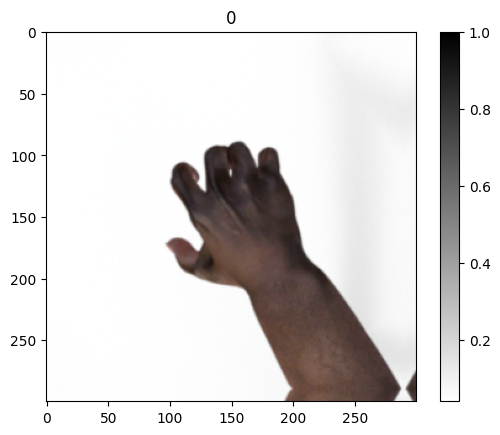

In [8]:
# Take one example from the training dataset
for image, label in ds_train.take(1):
    # Display the image
    plt.figure()
    plt.imshow(image[0], cmap=plt.cm.binary) # Access the first image in the batch
    plt.colorbar()
    plt.grid(False)
    plt.title(label[0].numpy()) # Display the label as the title
    plt.show()
    break # Exit the loop after taking one example

=== 5. DEFINE THE MODEL ARCHITECTURE ===
สร้างโครงสร้างของ Neural Network แบบเรียงต่อกัน

In [ ]:
model = tf.keras.models.Sequential([
    # Layer 1: Convolution + Pooling
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Layer 2: Convolution + Pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    # Layer 3: Convolution + Pooling
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # Flatten + Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(270, activation='relu'),
    tf.keras.layers.Dropout(0.6),   # กัน overfitting
    # Output Layer
    tf.keras.layers.Dense(3, activation='softmax')
])

g:\BU\Project\Ai\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


=== 6. COMPILE THE MODEL ===
กำหนดค่าสำหรับกระบวนการเทรน

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), # เลือกใช้ 'Adam' optimizer 
              loss='sparse_categorical_crossentropy', # เลือก Loss Function ที่เหมาะกับ Multi-class classification
              metrics=['accuracy']) # กำหนดให้แสดงค่า Accuracy เพื่อให้เราอ่านผลง่ายขึ้น

In [11]:
print("Training model...")
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
class_weights = {0:1.0, 1:1.0, 2:1.2}
history = model.fit(ds_train, epochs=50, validation_data=ds_val,class_weight=class_weights,callbacks=callbacks)

Training model...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 477ms/step - accuracy: 0.3333 - loss: 2.5048 - val_accuracy: 0.3016 - val_loss: 1.0997 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - accuracy: 0.3403 - loss: 1.1706 - val_accuracy: 0.3056 - val_loss: 1.1021 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.3333 - loss: 1.1681
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.3418 - loss: 1.1689 - val_accuracy: 0.3056 - val_loss: 1.1043 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.3899 - loss: 1.1400 - val_accuracy: 0.5655 - val_loss: 0.9604 - learning_rate: 5.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.6047 - loss: 0.9291 - val_accuracy: 0.8730 - val_loss: 0.5560 - learning_rate: 5.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - acc

=== 8. EVALUATE THE MODEL ===
พล็อตกราฟ Training & Validation Loss เพื่อดูแนวโน้มการเรียนรู้และตรวจสอบ Overfittingประเมินประสิทธิภาพสุดท้ายของโมเดลด้วย Test set


Visualizing training history...


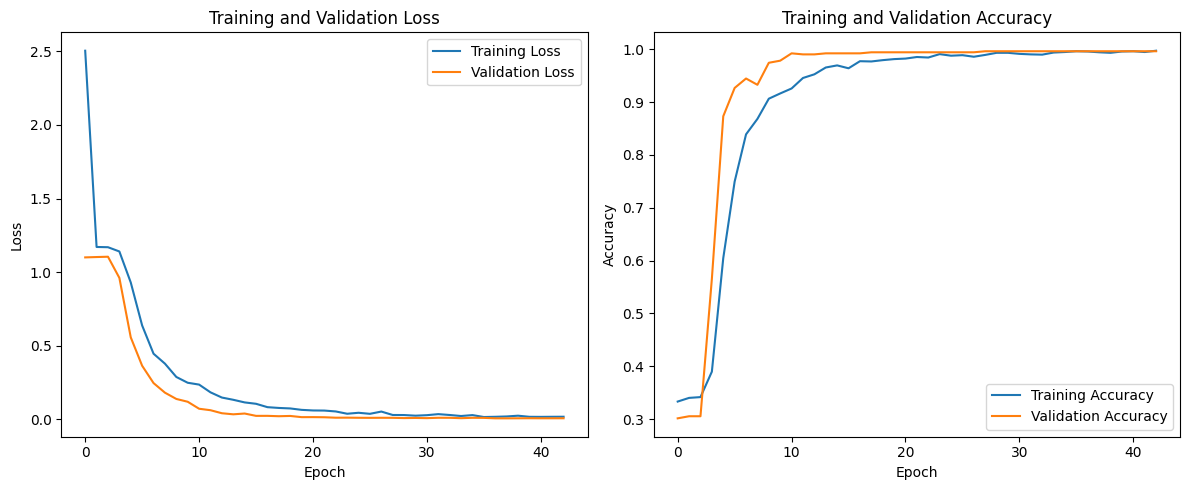

In [12]:
print("\nVisualizing training history...")

plt.figure(figsize=(12, 5))

# ----- Plot Loss -----
plt.subplot(1, 2, 1)  # ซับพล็อตช่องซ้าย
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ----- Plot Accuracy -----
plt.subplot(1, 2, 2)  # ซับพล็อตช่องขวา
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

=== 9. EVALUATE THE MODEL ON TEST DATA ===
ประเมินประสิทธิภาพสุดท้ายของโมเดลด้วย Test set ซึ่งเป็นข้อมูลที่โมเดลไม่เคยเห็นมาก่อน

In [13]:
print("\nEvaluating final model performance on the test set...")
test_loss, test_acc = model.evaluate(ds_test)
print(f'\nTest loss: {test_loss}')
print(f'Test accuracy: {test_acc}')


Evaluating final model performance on the test set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9382 - loss: 0.1784

Test loss: 0.17843899130821228
Test accuracy: 0.9381720423698425


In [14]:
# Install scikit-learn in the notebook environment if not already installed
%pip install --quiet scikit-learn

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# เก็บ y_true / y_pred
y_true, y_pred = [], []
for x, y in ds_test:
    p = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(p, axis=1))
    y_true.extend(y.numpy())

print(classification_report(y_true, y_pred, target_names=['rock','paper','scissors']))

cm = confusion_matrix(y_true, y_pred)
print(cm)


Note: you may need to restart the kernel to use updated packages.
              precision    recall  f1-score   support

        rock       1.00      0.89      0.94       124
       paper       0.93      0.93      0.93       124
    scissors       0.89      1.00      0.94       124

    accuracy                           0.94       372
   macro avg       0.94      0.94      0.94       372
weighted avg       0.94      0.94      0.94       372

[[110   8   6]
 [  0 115   9]
 [  0   0 124]]


In [15]:
# ฟังก์ชัน TTA
def tta_predict(model, x):
    views = [
        x,
        tf.image.flip_left_right(x),
        tf.image.rot90(x, 1),
        tf.image.rot90(x, 3)
    ]
    preds = [model(v, training=False) for v in views]
    return tf.reduce_mean(tf.stack(preds), axis=0)

# วัดผลบน test set
y_true, y_pred, losses = [], [], []

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

for images, labels in ds_test:
    batch_preds, batch_losses = [], []
    for img, label in zip(images, labels):
        img = tf.expand_dims(img, axis=0)  # (1,h,w,c)
        pred = tta_predict(model, img)
        batch_preds.append(tf.argmax(pred, axis=1).numpy()[0])
        # loss_fn expects tensors with matching shapes; expand label to shape (1,)
        batch_losses.append(loss_fn(tf.expand_dims(label, axis=0), pred).numpy())
    y_true.extend(labels.numpy())
    y_pred.extend(batch_preds)
    losses.extend(batch_losses)

# คำนวณค่าเฉลี่ย
test_loss = sum(losses) / len(losses)
test_acc = np.mean(np.array(y_true) == np.array(y_pred))

print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")



Test loss: 0.4441
Test accuracy: 0.9543
